[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Masao-Taketani/gan_practice/blob/master/dcgan.ipynb)


In [0]:
from glob import glob
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization,\
Activation, Dropout, Flatten, Dense, Reshape, UpSampling2D, LeakyReLU,\
ZeroPadding2D
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import RandomNormal

In [0]:
# hyper params
num_data = 20589
img_size = 128
channel_size = 3
batch_size = 32

input_dims = (img_size, img_size, channel_size)
num_disc_layers = 4
disc_conv_fils = [32, 64, 128, 256]
disc_conv_kernel_size = [3, 3, 3, 3]
disc_conv_strides = [2, 2, 2, 1]
disc_batch_norm_momentum = 0.8
disc_dropout_rate = 0.25

z_dims = 100
shape_after_dense = (img_size//4, img_size//4, 128)
gen_upsamp_layers = [True, True, False]
gen_batch_norm_momentum = 0.8
gen_dropout_rate = None
num_gen_layers = 3
gen_conv_fils = [128, 64, channel_size]
gen_conv_kernel_size = [3, 3, 3]

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [11]:
!tar -zxvf drive/My\ Drive/datasets/gan/dogs_data/tfrecords/tfrecords_as_one.tar.gz

tfrecords/
tfrecords/whole_dogs_data.tfrecord
tfrecords/.gitkeep


In [0]:
data_path = "tfrecords/whole_dogs_data.tfrecord"

In [0]:
def parse(example):
    features = tf.parse_single_example(
        example,
        features={
            'X': tf.FixedLenFeature([img_size * img_size * channel_size], dtype=tf.float32)
        })
    
    X = features['X']
    
    return X


def iterator(tfrecord_path, num_data):
    dataset = tf.data.TFRecordDataset([tfrecord_path]).map(parse)
    dataset = dataset.repeat(-1).batch(num_data)
    iterator = dataset.make_one_shot_iterator()

    X = iterator.get_next()
    X = tf.reshape(X, [-1, img_size, img_size, channel_size])
    
    return X

In [5]:
x_train = iterator(data_path, 20579)
x_train = tf.Session().run(x_train)
x_train.shape



Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


(20579, 128, 128, 3)

## Discriminator

In [6]:
disc_input = Input(shape=input_dims, name="disc_input")
x = disc_input

for i in range(num_disc_layers):
    x = Conv2D(filters=disc_conv_fils[i],
              kernel_size=disc_conv_kernel_size[i],
              strides=disc_conv_strides[i],
              padding="same",
              name="disc_conv_" + str(i)
              )(x)
    
    if i == 1:
        """
        Arguments:
        padding: Int, or tuple of 2 ints, or tuple of 2 tuples of 2 ints.
        If int: the same symmetric padding is applied to height and width.
        If tuple of 2 ints: interpreted as two different symmetric padding
            values for height and width: (symmetric_height_pad, symmetric_width_pad).
        If tuple of 2 tuples of 2 ints: interpreted 
            as ((top_pad, bottom_pad), (left_pad, right_pad))
        """
        x = ZeroPadding2D(padding=((0, 1), (0, 1)))(x)
        
    if disc_batch_norm_momentum and i > 0:
        x = BatchNormalization(momentum=disc_batch_norm_momentum)(x)
        
    x = LeakyReLU(alpha=0.2)(x)
    
    if disc_dropout_rate:
        x = Dropout(disc_dropout_rate)(x)
    
x = Flatten()(x)
disc_output = Dense(1, activation="sigmoid")(x)
disc_model = Model(disc_input, disc_output)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [7]:
disc_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
disc_input (InputLayer)      [(None, 128, 128, 3)]     0         
_________________________________________________________________
disc_conv_0 (Conv2D)         (None, 64, 64, 32)        896       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
disc_conv_1 (Conv2D)         (None, 32, 32, 64)        18496     
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 33, 33, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 33, 33, 64)        256   

## Generator

In [0]:
gen_input = Input(shape=(z_dims,), name="gen_input")
x = gen_input
x = Dense(np.prod(shape_after_dense))(x)
x = Activation("relu")(x)
x = Reshape(shape_after_dense)(x)
for i in range(num_gen_layers):
    if gen_upsamp_layers[i]:
        x = UpSampling2D()(x)
        
    x = Conv2D(gen_conv_fils[i],
              gen_conv_kernel_size[i],
              padding="same",
              name="gen_conv_" + str(i)
              )(x)
    
    if i < num_gen_layers - 1:
        if gen_batch_norm_momentum:
            x = BatchNormalization(
            momentum=gen_batch_norm_momentum)(x)
            
        x = Activation("relu")(x)
    else:
        x = Activation("tanh")(x)
        
gen_output = x
gen_model = Model(gen_input, gen_output)

In [9]:
gen_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gen_input (InputLayer)       [(None, 100)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 131072)            13238272  
_________________________________________________________________
activation (Activation)      (None, 131072)            0         
_________________________________________________________________
reshape (Reshape)            (None, 32, 32, 128)       0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 64, 64, 128)       0         
_________________________________________________________________
gen_conv_0 (Conv2D)          (None, 64, 64, 128)       147584    
_________________________________________________________________
batch_normalization_3 (Batch (None, 64, 64, 128)       512 

## Train the GAN

### compile discriminator train model

In [10]:
disc_model.compile(#optimizer=RMSprop(lr=0.0008),
                  optimizer=Adam(0.0002, 0.5),
                  loss="binary_crossentropy",
                  metrics=["accuracy"])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [11]:
# freeze the discriminator model so that it only makes
# the generator model train on this model
disc_model.trainable = False
comb_model_input = Input(shape=(z_dims,), name="comb_model_input")
comb_model_output = disc_model(gen_model(comb_model_input))
comb_model = Model(comb_model_input, comb_model_output)
comb_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
comb_model_input (InputLayer [(None, 100)]             0         
_________________________________________________________________
model_1 (Model)              (None, 128, 128, 3)       13462147  
_________________________________________________________________
model (Model)                (None, 1)                 464193    
Total params: 13,926,340
Trainable params: 13,461,763
Non-trainable params: 464,577
_________________________________________________________________


### compile generator train model

In [0]:
comb_model.compile(#optimizer=RMSprop(0.0004),
             optimizer=Adam(0.0002, 0.5),
             loss="binary_crossentropy",
             metrics=["accuracy"])

In [0]:
def train_disc(disc_model, gen_model, x_train, batch_size):
    # create 2-dim labels
    real_labels = np.ones((batch_size, 1))
    fake_labels = np.zeros((batch_size, 1))
    
    # train on real imgs
    # np.random.randint(min, max, size)
    idxes = np.random.randint(0, len(x_train), batch_size)
    real_imgs = x_train[idxes]
    
    disc_real_loss = disc_model.train_on_batch(real_imgs, real_labels)
    
    # train on fake imgs
    # np.random.normal(mean, std, size)
    # the blow follows the standard normal distribution
    noise = np.random.normal(0, 1, (batch_size, z_dims))
    fake_imgs = gen_model.predict(noise)
    
    disc_fake_loss = disc_model.train_on_batch(fake_imgs, fake_labels)
    disc_loss = 0.5 * np.add(disc_real_loss, disc_fake_loss)
    return disc_loss


def train_gen(comb_model, batch_size):
    real_labels = np.ones((batch_size, 1))
    noise = np.random.normal(0, 1, (batch_size, z_dims))
    
    gen_loss = comb_model.train_on_batch(noise, real_labels)
    return gen_loss


def plot_generated_imgs(rows, cols, noises, it, gen_model):
    print("iteration: ", it)

    gen_imgs = gen_model.predict(noises)

    # since gen model outputs values ranging from -1 to 1,
    # nomalize imgs ranging from 0 to 1
    #=====================================================================
    # matplotlib.pyplot.imshow(..., norm=None, ...):
    # By default, a linear scaling mapping the lowest value to 0 and
    # the highest to 1 is used. This parameter is ignored for RGB(A) data.
    #=====================================================================

    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(rows, cols)

    ith_img = 0
    for row in range(rows):
        for col in range(cols):
            try:
                axs[row, col].imshow(gen_imgs[ith_img,:,:,:])
                axs[row, col].axis("off")
                ith_img += 1
            except IndexError:
                axs[col].imshow(gen_imgs[ith_img,:,:,:])
                axs[col].axis("off")
                ith_img += 1

[training log]
iteration: 0 disc loss: 2.993190, disc acc: 14.06% | gen loss: 0.234088, gen acc: 0.97%
iteration:  0
iteration: 1000 disc loss: 0.988250, disc acc: 51.56% | gen loss: 2.516396, gen acc: 0.09%
iteration:  1000
iteration: 2000 disc loss: 1.062279, disc acc: 37.50% | gen loss: 0.590655, gen acc: 0.69%
iteration:  2000
iteration: 3000 disc loss: 1.117704, disc acc: 42.19% | gen loss: 1.116133, gen acc: 0.44%
iteration:  3000
iteration: 4000 disc loss: 0.585992, disc acc: 71.88% | gen loss: 0.968982, gen acc: 0.34%
iteration:  4000
iteration: 5000 disc loss: 0.816183, disc acc: 57.81% | gen loss: 1.158128, gen acc: 0.16%
iteration:  5000
iteration: 6000 disc loss: 1.533169, disc acc: 15.62% | gen loss: 0.381054, gen acc: 0.78%
iteration:  6000
iteration: 7000 disc loss: 0.609349, disc acc: 65.62% | gen loss: 0.924682, gen acc: 0.44%
iteration:  7000
iteration: 8000 disc loss: 0.632277, disc acc: 65.62% | gen loss: 1.378335, gen acc: 0.19%
iteration:  8000
iteration: 9000 dis

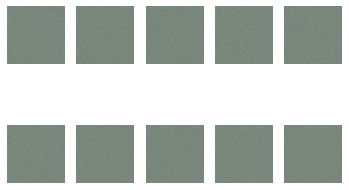

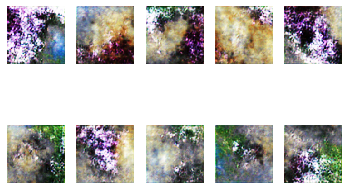

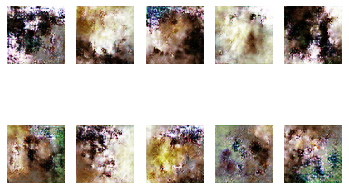

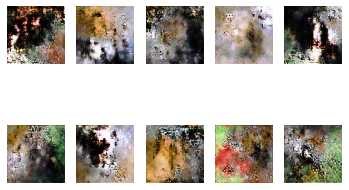

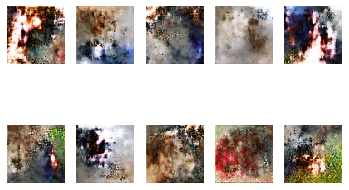

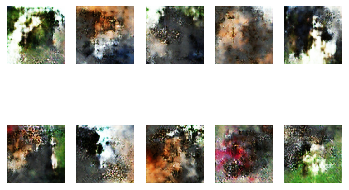

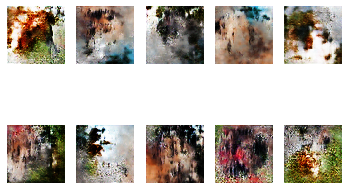

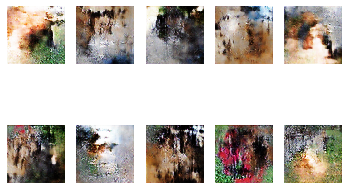

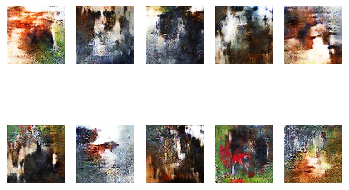

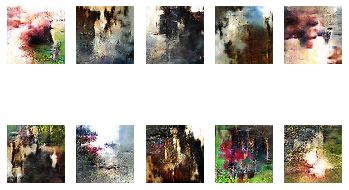

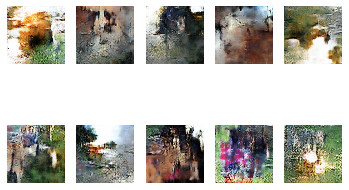

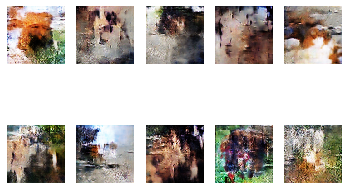

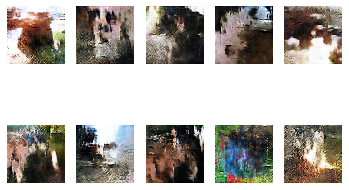

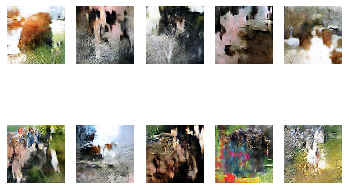

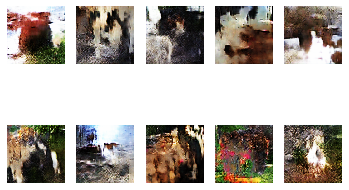

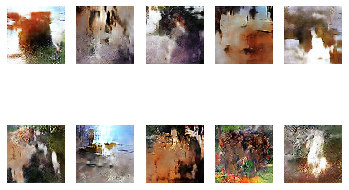

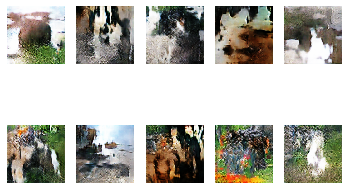

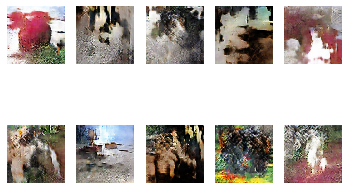

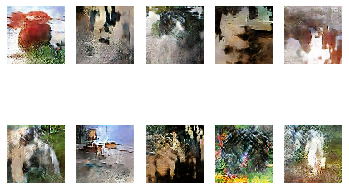

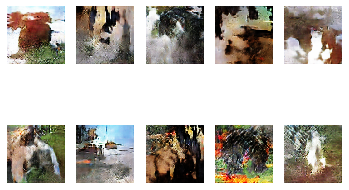

In [14]:
iterations = 20_000
rows, cols = 2, 5
np.random.seed(7)
noises = np.random.normal(0, 1, (rows * cols, z_dims))

print("[training log]")
for it in range(iterations):
    disc_loss = train_disc(disc_model, gen_model, x_train, batch_size)
    gen_loss = train_gen(comb_model, batch_size)
    
    if it % 1000 == 0:
        print("iteration: %d disc loss: %f, disc acc: %.2f%% | gen loss: %f, "
        "gen acc: %.2f%%" % 
          (it, disc_loss[0], 100 * disc_loss[1], gen_loss[0], gen_loss[1]))
        plot_generated_imgs(rows, cols, noises, it, gen_model)
        
print("[10 generated images for each 1000th iteration]")

In [30]:
gen_imgs = gen_model.predict(noises)
gen_imgs = 0.5 * gen_imgs + 0.5
gen_imgs.shape

(10, 128, 128, 3)

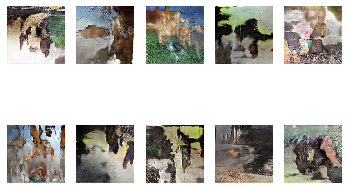

In [31]:
fig, axs = plt.subplots(rows, cols)

ith_img = 0
for row in range(rows):
    for col in range(cols):
        try:
            axs[row, col].imshow(gen_imgs[ith_img,:,:,:])
            axs[row, col].axis("off")
            ith_img += 1
        except IndexError:
            axs[col].imshow(gen_imgs[ith_img,:,:,:])
            axs[col].axis("off")
            ith_img += 1